In [25]:
import torch
import sys
sys.path.append('/public/home/wangxin5/nanptopem/Nanotope-main/Nanotope-main/Nanotope/data')

from GNNetNano import Nanotope  # 替换为您的模型定义所在的文件



In [26]:
import os
import sys
sys.path.append('/public/home/wangxin5/nanptopem/Nanotope-main/Nanotope-main/Nanotope/data')
# 设置设备为 cuda
device = torch.device('cuda:0')

print(f"Using device: {device}") 

import torch
# 初始化模型（确保与保存时的模型结构一致）
hidden_channels = 512
num_layers = 3
num_heads = 4
num_bases = 4


model = Nanotope(hidden_channels, num_layers, num_heads, num_bases)
model.to(device)

# 加载模型权重
model_path = '/public/home/wangxin5/model_weights-epoach80.pth'  # 替换为您的模型保存路径
model.load_state_dict(torch.load(model_path))
model.eval()  # 设置模型为评估模式


Using device: cuda:0


Nanotope(
  (Conv1D): Sequential(
    (0): Conv1d(512, 256, kernel_size=(5,), stride=(1,), padding=same, dilation=(4,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv1D_2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same, dilation=(4,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv1D_dilated): Sequential(
    (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (convs): ModuleList(
    (0-2): 3 x EGConv(512, 512, aggregators=['mean', 'sum', 'std', 'max', 'min'])
  )
  (norms): ModuleList(
    (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (attention): GATConv(512, 256, heads=2)
  (attention_batch): BatchNorm1d(512, eps=1e-05, m

In [27]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            
            batch = batch.to(device)
            output = model(batch)
            preds = (output > 0).float()  # 二分类的预测
            correct += (preds == batch.y).sum().item()
            total += batch.y.size(0)
    accuracy = correct / total
    return accuracy

In [28]:
import pandas as pd
import pickle
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_cluster import knn
from antiberty import AntiBERTyRunner
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
k=8

In [29]:
import pandas as pd
import pickle
# 加载 Parquet 文件
loaded_train = pd.read_parquet('/public/home/wangxin5/nanptopem/Nanotope-main/Nanotope-main/Nanotope/data/parquet/train_processed_serialized.parquet')
# 反序列化 'coord' 列
loaded_train['coord'] = loaded_train['coord'].apply(lambda x: pickle.loads(x) if isinstance(x, bytes) else [])
# 加载 Parquet 文件
loaded_val = pd.read_parquet('/public/home/wangxin5/nanptopem/Nanotope-main/Nanotope-main/Nanotope/data/parquet/val_processed_serialized.parquet')
# 反序列化 'coord' 列
loaded_val['coord'] = loaded_val['coord'].apply(lambda x: pickle.loads(x) if isinstance(x, bytes) else [])
# 加载 Parquet 文件
loaded_test = pd.read_parquet('/public/home/wangxin5/nanptopem/Nanotope-main/Nanotope-main/Nanotope/data/parquet/test_processed_serialized.parquet')
# 反序列化 'coord' 列
loaded_test['coord'] = loaded_test['coord'].apply(lambda x: pickle.loads(x) if isinstance(x, bytes) else [])

In [30]:
loaded_test

,sequence,paratope_labels,PDB/ nano_chain/ antigen_chain,PDB,nano_chain,antigen_chain,coord
0,EVQLVESGGGLIQPGGSLRLSCAASGFTVSSNYMSWVRQAPGKGLE...,"[N, P, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",7chp H anti E,7chp,H,anti E,"[[-20.12700080871582, 51.38800048828125, 2.904..."
1,AVQLVESGGGLVQPGGSLRLSCAASVSISRIYVMAWYRQAPGKQRE...,"[N, P, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",8gni C anti A,8gni,C,anti A,"[[226.54400634765625, 163.38499450683594, 206...."
2,QVQLQQPGAELVKPGASVKLSCKASGYTFTSDWIHWVKQRPGHGLE...,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",2ih1 A anti C,2ih1,A,anti C,"[[47.308998107910156, 44.262001037597656, -14...."
3,EMQLQQSGAELLRPGTSVKLSCKTSGYIFTSYWIHWVKQRSGQGLE...,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",1yej H anti L,1yej,H,anti L,"[[9.531999588012695, 58.20600128173828, 71.622..."
4,EVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYMYWVRQAPGQGLE...,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",6vmj B anti Z,6vmj,B,anti Z,"[[12.220000267028809, -108.27400207519531, 22...."
...,...,...,...,...,...,...,...
491,EVQLQASGGGLVRPGGSLRLSCAASGFTFSSYAMMWVRQAPGKGLE...,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",7n0r C anti A,7n0r,C,anti A,"[[23.756000518798828, -0.08500000089406967, 13..."
492,EVQLQASGGGLVRPGGSLRLSCAASGFTFSSYAMMWVRQAPGKGLE...,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",7n0r D anti B,7n0r,D,anti B,"[[25.858999252319336, 13.930000305175781, -9.3..."
493,VQLVESGAEVKKPGSSVKVSCKASGDTFIRYSFTWVRQAPGQGLEW...,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",2i60 H anti G,2i60,H,anti G,"[[8.395000457763672, 12.045999526977539, 26.81..."
494,EVQLVESGAEVKKPGSSVKVSCKASGDTFIRYSFTWVRQAPGQGLE...,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...",2i60 R anti P,2i60,R,anti P,"[[13.013999938964844, 23.534000396728516, 29.8..."


In [78]:
label_true=[]
def make_data(df):
    
    dataset = []
    for seq,label,coord in tqdm(zip(df['sequence'],df['paratope_labels'],df['coord'])):
        seq = [seq]
        size = len(seq[0])

        # 生成 0/1 列表
        binary_list = [1 if lbl == 'P' else 0 for lbl in label]


        # 使用 np.pad 进行填充
        if len(binary_list) < 140:
            pad_length = 140 - len(binary_list)
            binary_list = np.pad(binary_list, (0, pad_length), 'constant', constant_values=0)
        elif len(binary_list) > 140:
            binary_list = binary_list[:140]

        # 转为张量
        label_tensor = torch.tensor(binary_list, dtype=torch.long)

        coord = torch.tensor(coord)
        
        Antiberty = AntiBERTyRunner()
        embeddings = Antiberty.embed(seq)[0][1:-1]

        if size<140:
            pad = torch.zeros((140-size),512).cuda()
            embeddings =torch.cat([embeddings,pad],dim=0)
        elif size > 140:
            embeddings = embeddings[:140].cuda()  # 截断超长部分
        
            
        edge_index = knn(coord,coord,k = k)
        data = Data(x = embeddings, y= label_tensor,edge_index=edge_index,mask=size)
        label_true.append(label_tensor)
        dataset.append(data)
        
    return dataset


In [79]:
train_datasetx = make_data(loaded_train[:100])

100it [00:44,  2.26it/s]


In [32]:
train_dataset = make_data(loaded_train[:100])
test_dataset = make_data(loaded_test[:100])
# val_dataset = make_data(loaded_val[:])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True) 
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True) 


100it [00:37,  2.66it/s]
100it [00:37,  2.64it/s]


In [33]:
# 评估模型在验证集上的表现
# val_accuracy = evaluate(model, val_loader, device)
# print(f"Validation Accuracy: {val_accuracy:.4f}")

# 评估模型在测试集上的表现
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 15.9100


In [34]:
# 预测函数
def predict(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)
            preds = torch.sigmoid(output).cpu().numpy()
            labels = batch.y.cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import numpy as np


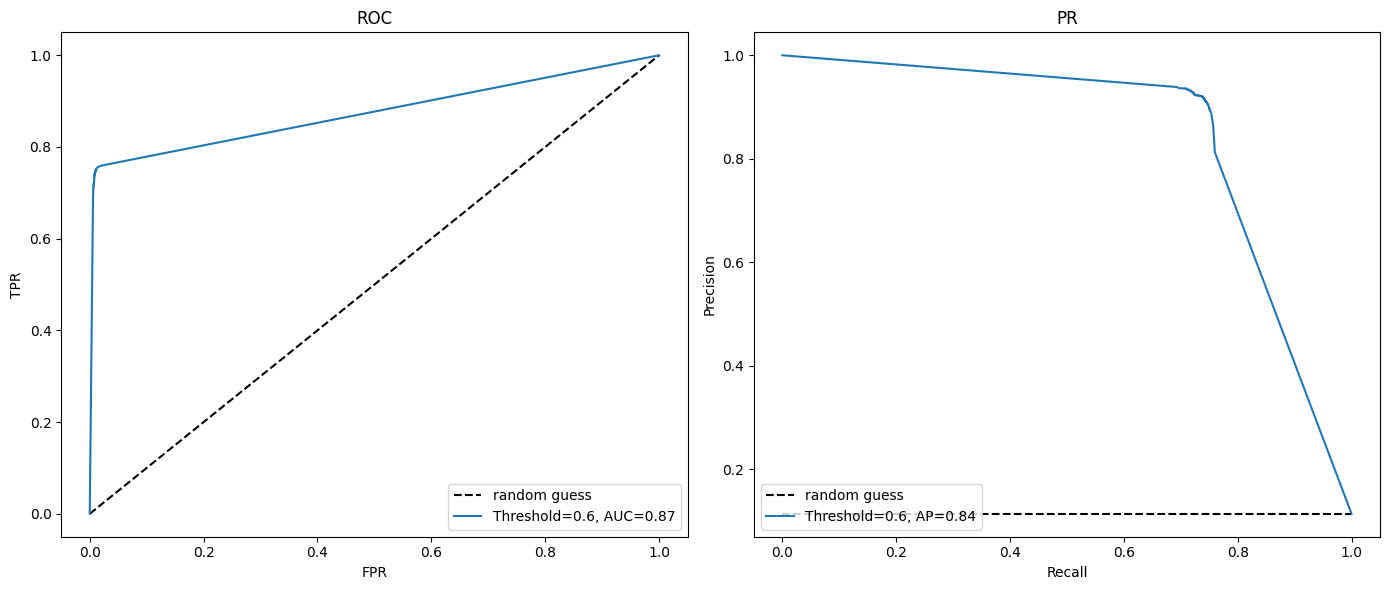

Threshold=0.6:
  ROC AUC: 0.8747, 评价: 模型性能良好
  PR AP: 0.7391, 评价: 模型性能良好



In [36]:
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import font_manager

# font_path="/public/home/wangxin5/nanptopem/Nanotope-main/Nanotope-main/Nanotope/data/SimHei.ttf"
# font_prop = font_manager.FontProperties(fname=font_path)

# 设置字体为SimHei（黑体）
# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# 获取预测结果和真实标签
y_scores, y_true = predict(model, test_loader, device)
# print(y_scores.shape)
# 将概率标签转换为二分类标签
# 定义多个Threshold
threshold =  0.6

# 初始化绘图
plt.figure(figsize=(14, 6))

# 绘制 ROC 曲线
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--', label='random guess')

# 将预测概率转换为二分类标签
y_true_binary = (y_scores >= threshold).astype(int)
try:
    # 计算 ROC 曲线和 AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f'Threshold={threshold}, AUC={roc_auc:.2f}')
except ValueError as e:
    print(f"Error for threshold {threshold}: {e}")

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')

# 绘制 PR 曲线
plt.subplot(1, 2, 2)
plt.plot([0, 1], [y_true.mean(), y_true.mean()], 'k--', label='random guess')

y_true_binary = (y_scores >= threshold).astype(int)
# 计算 PR 曲线和 
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)
# 绘制 PR 曲线
plt.plot(recall, precision, label=f'Threshold={threshold}, AP={pr_auc:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR')
plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig('roc_pr_curve.jpg', dpi=300, bbox_inches='tight')  # 保存图像
plt.show()

# 评估每个Threshold下的模型性能
def evaluate_model(y_true, y_scores, threshold):
    # 将预测概率转换为二分类标签
    y_pred = (y_scores >= threshold).astype(int)
    # 计算 AUC
    roc_auc = roc_auc_score(y_true, y_scores)
    # 计算 AP
    ap = average_precision_score(y_true, y_scores)
    # 评价
    if roc_auc > 0.9:
        auc_evaluation = '模型性能非常好'
    elif 0.7 < roc_auc < 0.9:
        auc_evaluation = '模型性能良好'
    elif 0.5 < roc_auc < 0.7:
        auc_evaluation = '模型性能一般'
    else:
        auc_evaluation = '模型性能较差'
    
    if ap > 0.9:
        ap_evaluation = '模型性能非常好'
    elif 0.7 < ap < 0.9:
        ap_evaluation = '模型性能良好'
    elif 0.5 < ap < 0.7:
        ap_evaluation = '模型性能一般'
    else:
        ap_evaluation = '模型性能较差'
    
    return roc_auc, ap, auc_evaluation, ap_evaluation

roc_auc, ap, auc_eval, ap_eval = evaluate_model(y_true, y_scores, threshold)
print(f'Threshold={threshold}:')
print(f'  ROC AUC: {roc_auc:.4f}, 评价: {auc_eval}')
print(f'  PR AP: {ap:.4f}, 评价: {ap_eval}\n')

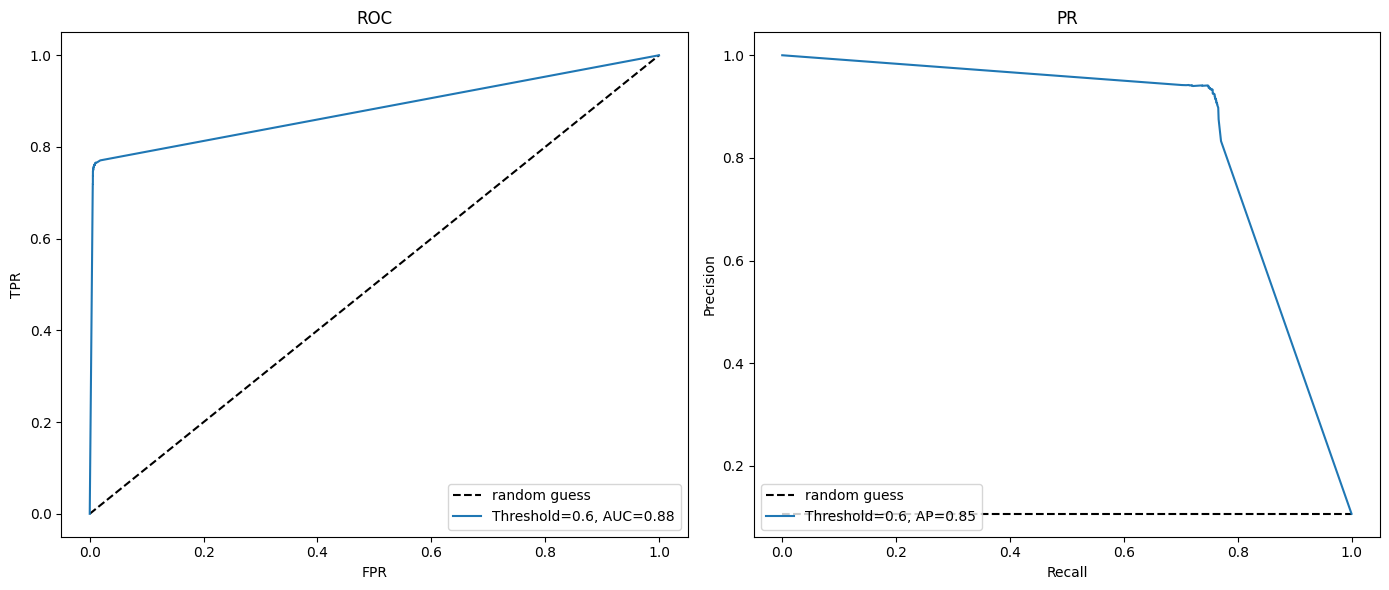

Threshold=0.6:
  ROC AUC: 0.8810, 评价: 模型性能良好
  PR AP: 0.7496, 评价: 模型性能良好



In [53]:
# 获取预测结果和真实标签
y_scores, y_true = predict(model, train_loader, device)
# print(y_scores.shape)
# 将概率标签转换为二分类标签
# 定义多个Threshold
threshold =  0.6

# 初始化绘图
plt.figure(figsize=(14, 6))

# 绘制 ROC 曲线
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--', label='random guess')

# 将预测概率转换为二分类标签
y_true_binary = (y_scores >= threshold).astype(int)
try:
    # 计算 ROC 曲线和 AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f'Threshold={threshold}, AUC={roc_auc:.2f}')
except ValueError as e:
    print(f"Error for threshold {threshold}: {e}")

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')

# 绘制 PR 曲线
plt.subplot(1, 2, 2)
plt.plot([0, 1], [y_true.mean(), y_true.mean()], 'k--', label='random guess')

y_true_binary = (y_scores >= threshold).astype(int)
# 计算 PR 曲线和 
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)
# 绘制 PR 曲线
plt.plot(recall, precision, label=f'Threshold={threshold}, AP={pr_auc:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR')
plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig('roc_pr_curve.jpg', dpi=300, bbox_inches='tight')  # 保存图像
plt.show()

# 评估每个Threshold下的模型性能
def evaluate_model(y_true, y_scores, threshold):
    # 将预测概率转换为二分类标签
    y_pred = (y_scores >= threshold).astype(int)
    # 计算 AUC
    roc_auc = roc_auc_score(y_true, y_scores)
    # 计算 AP
    ap = average_precision_score(y_true, y_scores)
    # 评价
    if roc_auc > 0.9:
        auc_evaluation = '模型性能非常好'
    elif 0.7 < roc_auc < 0.9:
        auc_evaluation = '模型性能良好'
    elif 0.5 < roc_auc < 0.7:
        auc_evaluation = '模型性能一般'
    else:
        auc_evaluation = '模型性能较差'
    
    if ap > 0.9:
        ap_evaluation = '模型性能非常好'
    elif 0.7 < ap < 0.9:
        ap_evaluation = '模型性能良好'
    elif 0.5 < ap < 0.7:
        ap_evaluation = '模型性能一般'
    else:
        ap_evaluation = '模型性能较差'
    
    return roc_auc, ap, auc_evaluation, ap_evaluation

roc_auc, ap, auc_eval, ap_eval = evaluate_model(y_true, y_scores, threshold)
print(f'Threshold={threshold}:')
print(f'  ROC AUC: {roc_auc:.4f}, 评价: {auc_eval}')
print(f'  PR AP: {ap:.4f}, 评价: {ap_eval}\n')

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, matthews_corrcoef

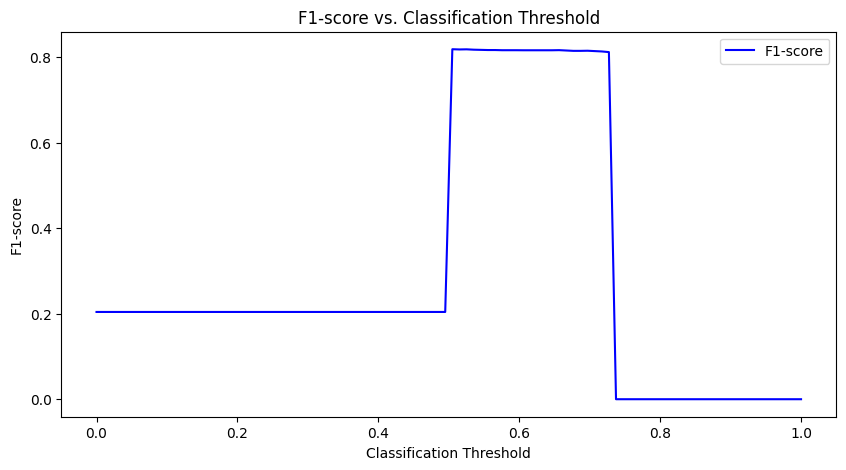

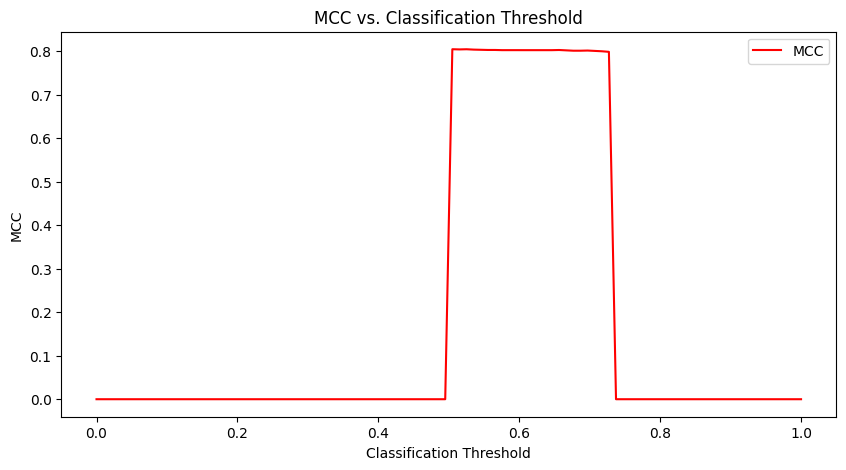

In [38]:

# 获取预测结果和真实标签
y_scores, y_true = predict(model, test_loader, device)
thresholds = np.linspace(0, 1, 100)  # 生成100个阈值（0~1）
f1_scores = []
mcc_scores = []

for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)  # 根据阈值分类
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1_scores.append(f1)
    mcc_scores.append(mcc)

# 绘制 F1-score 曲线
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label="F1-score", color="blue")
plt.xlabel("Classification Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs. Classification Threshold")
plt.legend()
# plt.grid(True)
plt.savefig('f1_score_curve.jpg', dpi=300, bbox_inches='tight')  # 保存图像
plt.show()

# 绘制 MCC 曲线
plt.figure(figsize=(10, 5))
plt.plot(thresholds, mcc_scores, label="MCC", color="red")
plt.xlabel("Classification Threshold")
plt.ylabel("MCC")
plt.title("MCC vs. Classification Threshold")
plt.legend()
# plt.grid(True)
plt.savefig('mcc_score_curve.jpg', dpi=300, bbox_inches='tight')  # 保存图像
plt.show()